# Experiment 3 & 4: PCA and K-Means Clustering
## 1. Import Libraries and Load Data
Loading the Breast Cancer dataset and importing necessary modules.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import adjusted_rand_score, silhouette_score
from manualPCA import ManualPCA
from Kmeans import Kmeans


data = load_breast_cancer()
X = data.data
y = data.target

## 2. Dimensionality Reduction using PCA
Applying Manual PCA to reduce the dataset dimensions to 2 components for visualization.

In [14]:
pca= ManualPCA(n_components=2)
X_projected = pca.fit_transform(X)
print("Shape of original data:", X.shape)
print("Shape of transformed data:", X_projected.shape)

Shape of original data: (569, 30)
Shape of transformed data: (569, 2)


## 3. K-Means Clustering on Projected Data
Applying K-Means clustering on the PCA-reduced data and visualizing the clusters and centroids.

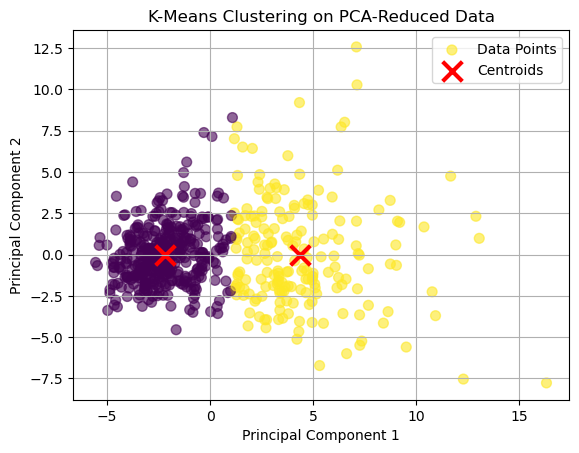

In [15]:
kmeans = Kmeans(k=2, max_iter=100)
kmeans.fit(X_projected)
labels = kmeans.predict(X_projected)
centrodis = kmeans.centroids



plt.scatter(X_projected[:, 0], X_projected[:, 1], 
            c=labels, cmap='viridis', s=50, alpha=0.6, label='Data Points')
plt.scatter(centrodis[:, 0], centrodis[:, 1], 
            c='red', marker='x', s=200, linewidths=3, label='Centroids')

plt.title('K-Means Clustering on PCA-Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

## 4. Impact of Number of Components
Testing PCA with different numbers of components (2, 5, 10, 15, 20) to analyze the trade-off between information preservation (Variance) and Reconstruction Error.

N_Components    | Preserved Var (%)    | Reconstruction Error
-----------------------------------------------------------------
2               | 63.24                | 809.7928            
5               | 84.73                | 729.8173            
10              | 95.16                | 515.5582            
15              | 98.65                | 249.0515            
20              | 99.56                | 51.4036             


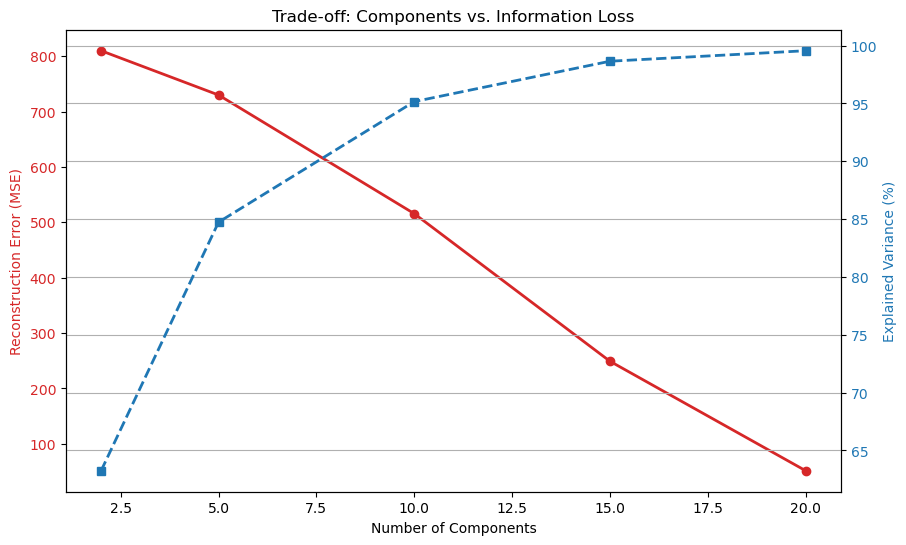

In [16]:
components_counts=[2,5,10,15,20]
errors=[]
variances=[]

print(f"{'N_Components':<15} | {'Preserved Var (%)':<20} | {'Reconstruction Error':<20}")
print("-" * 65)

for com in components_counts:
    pca= ManualPCA(n_components=com)
    X_projected = pca.fit_transform(X)
    X_reconstructed = pca.inverse_transform(X_projected)
    current_error=pca.compute_reconstruction_error(X, X_projected)
    variance = np.sum(pca.explained_variance_ratio) * 100 #pca.explained_variance_ratio_.sum() * 100
    errors.append(current_error)
    variances.append(variance)
    print(f"{com:<15} | {variance:<20.2f} | {current_error:<20.4f}")



# Plotting the trade-off   
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Reconstruction Error (MSE)', color=color)
ax1.plot(components_counts, errors, marker='o', color=color, linewidth=2, label='Error')
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Explained Variance (%)', color=color)
ax2.plot(components_counts, variances, marker='s', linestyle='--', color=color, linewidth=2, label='Variance')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Trade-off: Components vs. Information Loss')
plt.grid(True)
plt.show()

## 5. Dimensionality vs. Clustering Quality
Analyzing how the number of PCA components affects the clustering quality (ARI and Silhouette Score) compared to the baseline (original data).

N_Components    | Adjusted Rand Index (ARI) | Silhouette Score    
----------------------------------------------------------------------
2               | 0.6650               | 0.5081              
5               | 0.6707               | 0.3932              
10              | 0.6709               | 0.3554              
15              | 0.6765               | 0.3481              
20              | 0.6709               | 0.3434              
Full Data KMeans | 0.4914               | 0.6973              


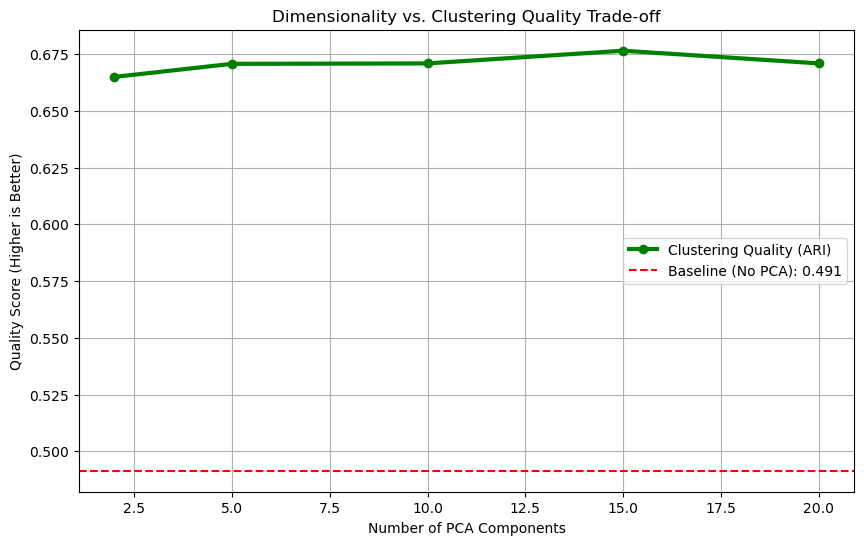

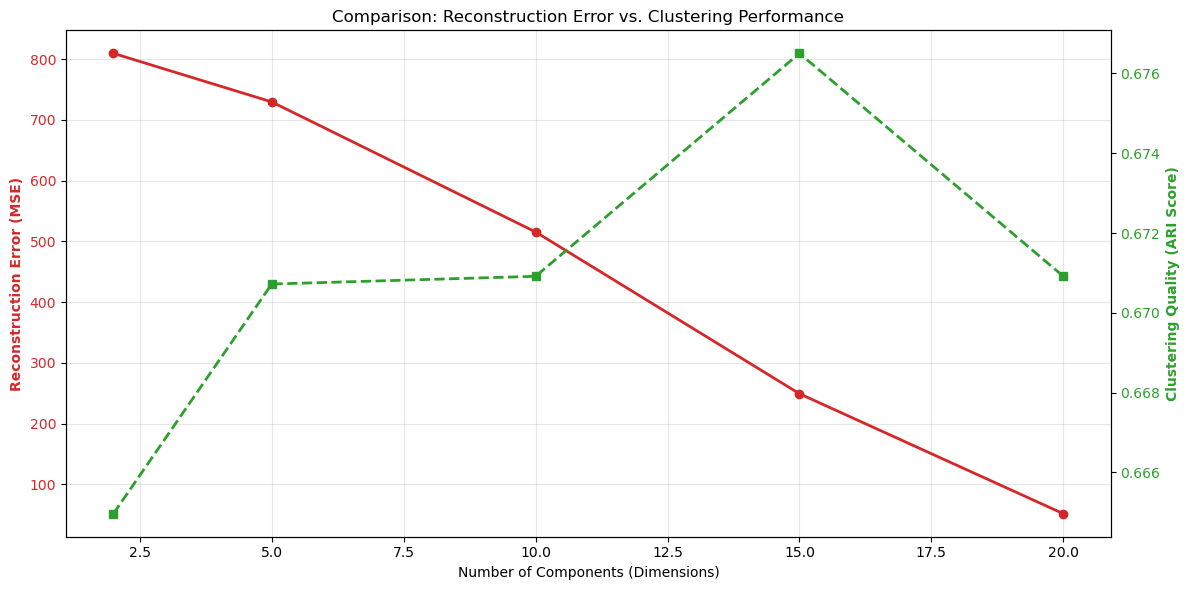

In [21]:
ari_scores = []       
silhouette_scores = [] 


print(f"{'N_Components':<15} | {'Adjusted Rand Index (ARI)':<20} | {'Silhouette Score':<20}")
print("-" * 70)
for com in components_counts:
    pca= ManualPCA(n_components=com)
    X_projected = pca.fit_transform(X)
    kmeans = Kmeans(k=2, max_iter=100)
    kmeans.fit(X_projected)
    labels = kmeans.predict(X_projected)
    ari= adjusted_rand_score(y, labels)
    ari_scores.append(ari)
    silhouette= silhouette_score(X_projected, labels)
    silhouette_scores.append(silhouette)
    print(f"{com:<15} | {ari:<20.4f} | {silhouette:<20.4f}")
    
# Plotting the clustering metrics
plt.figure(figsize=(10, 6))
plt.plot(components_counts, ari_scores, marker='o', linewidth=3, color='green', label='Clustering Quality (ARI)')



# compare with full kmeans on original data
kmeans_full = Kmeans(k=2, max_iter=100)
kmeans_full.fit(X)
labels_full = kmeans_full.predict(X)
ari_full= adjusted_rand_score(y, labels_full)
silhouette_full= silhouette_score(X, labels_full)
print(f"Full Data KMeans | {ari_full:<20.4f} | {silhouette_full:<20.4f}")
plt.axhline(y=ari_full, color='red', linestyle='--', label=f'Baseline (No PCA): {ari_full:.3f}')



plt.title('Dimensionality vs. Clustering Quality Trade-off')
plt.xlabel('Number of PCA Components')
plt.ylabel('Quality Score (Higher is Better)')
plt.legend()
plt.grid(True)
plt.show()


fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Number of Components (Dimensions)')
ax1.set_ylabel('Reconstruction Error (MSE)', color=color, fontweight='bold')
ax1.plot(components_counts, errors, color=color, marker='o', linestyle='-', linewidth=2, label='PCA Error (Lower is better)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()  
color = 'tab:green'
ax2.set_ylabel('Clustering Quality (ARI Score)', color=color, fontweight='bold')
ax2.plot(components_counts, ari_scores, color=color, marker='s', linestyle='--', linewidth=2, label='Clustering Quality (Higher is better)')
ax2.tick_params(axis='y', labelcolor=color)


plt.title('Comparison: Reconstruction Error vs. Clustering Performance')
fig.tight_layout()  
plt.show()

## 6. Conclusion: K-Means after PCA

### Key Findings:
1. **Dimensionality Reduction & Performance**: Applying PCA before K-Means can significantly reduce computational complexity while maintaining (or sometimes improving) clustering performance.
2. **Noise Reduction**: Lower dimensions (e.g., 2 or 5 components) often capture the main structure of the data while filtering out noise, which can lead to better separation of clusters.
3. **Trade-off**: 
    - **Too few components** (high reconstruction error) might lose critical information needed for separation.
    - **Too many components** might re-introduce noise and the "curse of dimensionality," potentially degrading K-Means performance.
4. **Optimal Balance**: The charts above help identify the "sweet spot" where we retain enough variance (low error) to represent the data accurately while keeping dimensions low enough for efficient and effective clustering.